#Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems.

There are two main benefits:
1. Can leverage an existing neural network achitecture proven to work on a similar problem.
2. Can leverage our working nueral network architecture which has already learned patterns on a similar data to our own then we can adapt those patterns to our own data

In [ ]:
#Are we using a gpu
!nvidia-smi

Sun Aug  6 11:43:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Downlaod and become one with the data

In [ ]:
#Get data(10% of 10 food classes from Food101)
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#Unzip the file
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-08-06 11:43:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.5MB/s    in 8.1s    

2023-08-06 11:43:41 (19.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#How many images in each folder?
import os

#Walk through 10 percent data directory and list number of files
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger

##Creating data loader(preparing the data)

We'll use the ImageDtaGenerator class to load our data in batches

In [ ]:
#Setup the inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Image_shape=(224,224)
Batch_size=32

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        target_size=Image_shape,
                                                        batch_size=Batch_size,
                                                        class_mode="categorical")
print("Testing images:")
test_data_10_percent=test_datagen.flow_from_directory(test_dir,
                                                      target_size=Image_shape,
                                                      batch_size=Batch_size,
                                                      class_mode="categorical")

Training Images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


##Setting up callbacks(rhings to run while our model trains)

Calback are extra functionality you can add to your models to be performed during or after training. Som eof the most popular callbacks:

* Tracking experiments with the TensorBoard callbacks
* Model checkpoint with the ModelCheckpoint callback
* Stopping a  model from training with EarlyStopping callbacks

In [ ]:
# Create TensorBoard callback(functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name + "/"+experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H")
  tensorboard_callback=tf.keras.callbacks.TensorBoard
  print(f"Saving TensorBoard log files to: {log_dir} ")
  return tensorboard_callback

##Creating models using TensorFlow Hub

In the past we've used TensorFlow to craete our own models layer by labyer by scratch

Now we're going to do a similar process, except majority of our model's layers are going to come form TensorFlow Hub

We can access pretrained models on:https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
#Let's compare the folowing two models
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"

efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
#Import dependancies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
#Let's make a create_model() function to create a model from a URL
def create_model(model_url,num_classes=10):
  """
  Takes a TensorFlow Hub URL and create a Keras Sequential model with it

  Args:
    model_irl(str):A TensorFlow Hub feature extraction url
    num_classes(int): Number of output neurons in the output layer,
      should be equal to number of target classes,  default 10.

    Returns:
      An uncompiled Keras Sequential model with model_url as a feature extractor
      layer and Dense output layer with num_classes output neurons.
  """
  #Download the pretrained model and save it as Keras layer
  feature_extractor_layer=hub.KerasLayer(model_url,
                                         trainable=False,#freeze already learned patterns
                                         name="feature_extraction_layer",
                                         input_shape=Image_shape+(3,))

  #Create our own model
  model=tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])
  return model

###Creating ResNet TensorFlow Hub Feature Extraction Model

In [ ]:
#Create Resnet model
resnet_model=create_model(resnet_url,
                          num_classes=train_data_10_percent.num_classes)

In [ ]:
#Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

# Create a TensorBoard callback with the log directory
log_dir = "tensorflow_hub/resnet50v2/20230806-04"
tensorboard_callback = TensorBoard(log_dir=log_dir)

# Fit the model using the updated TensorBoard callback
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[tensorboard_callback])


Epoch 1/5
24/24 [==============================] - 25s 550ms/step - loss: 2.8606 - accuracy: 0.2747 - val_loss: 1.3122 - val_accuracy: 0.5652
Epoch 2/5
24/24 [==============================] - 11s 471ms/step - loss: 1.1123 - accuracy: 0.6480 - val_loss: 0.9507 - val_accuracy: 0.6956
Epoch 3/5
24/24 [==============================] - 10s 439ms/step - loss: 0.7606 - accuracy: 0.7733 - val_loss: 0.8454 - val_accuracy: 0.7244
Epoch 4/5
24/24 [==============================] - 12s 493ms/step - loss: 0.6092 - accuracy: 0.8053 - val_loss: 0.8041 - val_accuracy: 0.7408
Epoch 5/5
24/24 [==============================] - 11s 455ms/step - loss: 0.4870 - accuracy: 0.8560 - val_loss: 0.7715 - val_accuracy: 0.7492


Feature extractor model out performed all previos models built in module 3 with only 10% of training examples

In [ ]:
#Let's create a function to plot our loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_acc=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #Plot loss
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_acc,label="val_acc")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

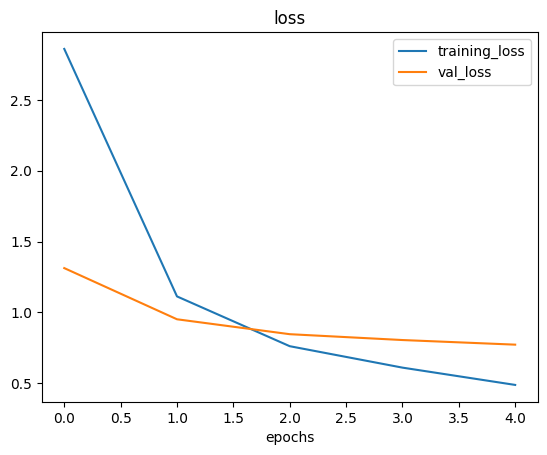

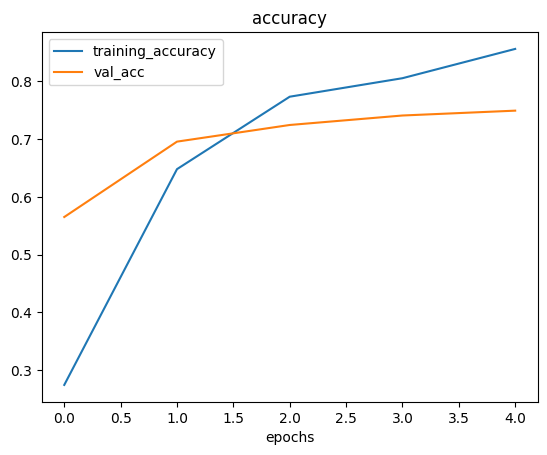

In [ ]:
plot_loss_curves(resnet_history)

###Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
#Create EfficientNet model
efficientnet_model=create_model(efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

In [ ]:
#Compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [ ]:
#Fit the model
log_dir = "tensorflow_hub/efficientnet50/20230806-11"
tensorboard_callback = TensorBoard(log_dir=log_dir)

history_efficientnet=efficientnet_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data_10_percent,
                                            validation_steps=len(test_data_10_percent),
                                            callbacks=[tensorboard_callback])

Epoch 1/5
24/24 [==============================] - 23s 515ms/step - loss: 1.7705 - accuracy: 0.4840 - val_loss: 1.2415 - val_accuracy: 0.7376
Epoch 2/5
24/24 [==============================] - 9s 399ms/step - loss: 1.0223 - accuracy: 0.7800 - val_loss: 0.8410 - val_accuracy: 0.8212
Epoch 3/5
24/24 [==============================] - 10s 432ms/step - loss: 0.7345 - accuracy: 0.8467 - val_loss: 0.6816 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 10s 441ms/step - loss: 0.5902 - accuracy: 0.8693 - val_loss: 0.5995 - val_accuracy: 0.8564
Epoch 5/5
24/24 [==============================] - 10s 437ms/step - loss: 0.5003 - accuracy: 0.8907 - val_loss: 0.5467 - val_accuracy: 0.8664


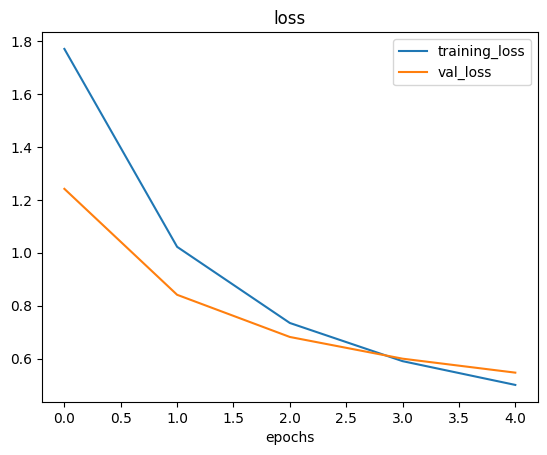

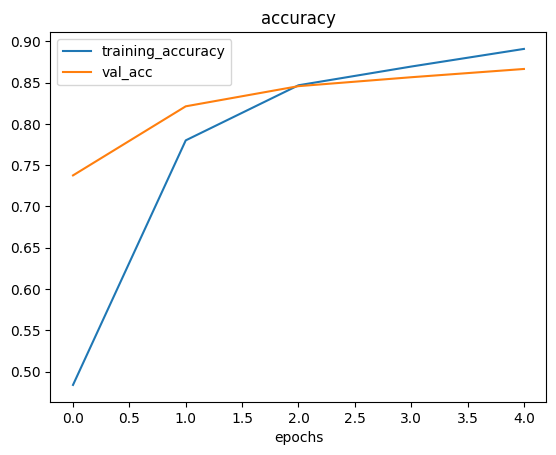

In [ ]:
#Plot loss curves
plot_loss_curves(history_efficientnet)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


##Different types of transfer learning

* **"As is" transfer learning** - using an existing model wtih no changes what so ever.
* **"Feature extraction" transfer learning** - using a prelearned patterns of a preexisting model and adjust the output layer for your problem
* **"Fine-tuning" transfer learning**- use the prelearned patterns of an existing model and fine tune many or all the underlying layers including new output layers.

##Comparing our results using TensorBoard

In [ ]:
#Upload TensorBoard dev records
!TesnorBoard dev upload --logdir ./tensorflow_hub/ \
  --name "efficientnet50 vs. resnet50v2" \
  --description "Comparing two different TB Hub feature extraction model architecture" \
  --one_shot

/bin/bash: line 1: TesnorBoard: command not found
